In [ ]:
#This notebook parses .mp4 videos of large numbers (1000s) of beads
#Efficiency is improved with compartmentalized bead tracking

In [255]:
base_dir = ''
sub = '/'
run = ''
filename = base_dir + sub + run + '.mp4'
d_count = 297 #number of data points in file
d_frames = 1 #number of frames analyzed per data point
t_interval = 1 #time interval between data points
framerate = 1 #hz

In [256]:
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import imageio
from PIL import Image, ImageDraw, ImageFont
import json

In [257]:
def get_ims(name):
    print('getting ims', end='\r')
    cap = cv2.VideoCapture(name)

    images = []

    while True:
        ret, frame = cap.read()

        if not ret:
            break  # End of video
        images.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

    cap.release()
    print('got ims', end = '\r')

    return images

In [258]:
def binarize(ims):
    binarized_ims = []
    c = 0
    for im in ims:
        print('binarising %s'%c, end='\r')
        binarized = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91, 15)

        binarized_ims.append(binarized)
        c += 1

    return binarized_ims

In [259]:
def get_beads(im):
    beads = {i:{} for i in range(25)}
    contours, _ = cv2.findContours(im, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    count = 0

    for cnt in contours:
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (float(x), float(y))
        radius = float(radius)

        if 15 > radius > 5: #2-10 for half res, 5-15 for x1.5 res, 10-20 for full res
            if 10 <= center[0] <= 1990 and 10 <= center[1] <= 1990: #also edit this for frame size
                compartment = int(center[0]/400)*5 + int(center[1]/400)
                beads[compartment][count] = {'centers':[center],
                                'radii':[radius],
                                'viable':True,
                                'travel':[0],
                                'travel_um':[0],
                                'integrated_travel':[0],
                                'distance_from_start':[0],
                                'integrated_frame_travel':[[0,0]]}
                count += 1

    return beads

In [260]:
def match_beads(prev_beads, current_beads, max_distance_threshold):
    matched_beads = prev_beads.copy()
    frame_vector = (0,0)
    bead_count = 0

    for compartment in prev_beads:
        for bead in prev_beads[compartment]:
            if prev_beads[compartment][bead]['viable']:
                min_dist = 10*max_distance_threshold
                closest_current_center = None
                radius = None
                r_change = 0

                for c_bead in current_beads[compartment]:
                    distance = np.linalg.norm(np.array(current_beads[compartment][c_bead]['centers'][0]) - np.array(prev_beads[compartment][bead]['centers'][-1]))

                    if distance < min_dist:
                        min_dist = distance
                        closest_current_center = current_beads[compartment][c_bead]['centers'][0]
                        radius = current_beads[compartment][c_bead]['radii'][0]
                        r_change = abs(radius - prev_beads[compartment][bead]['radii'][-1])

                if closest_current_center is not None and min_dist < max_distance_threshold and r_change < 10:
                    matched_beads[compartment][bead]['centers'].append(closest_current_center)
                    matched_beads[compartment][bead]['radii'].append(radius)

                    frame_vector = np.add(frame_vector, np.subtract(matched_beads[compartment][bead]['centers'][-1], matched_beads[compartment][bead]['centers'][-2]))
                    bead_count += 1
                else:
                    matched_beads[compartment][bead]['viable'] = False

        frame_average = np.divide(frame_vector, bead_count)

        for bead in matched_beads[compartment]:
            if matched_beads[compartment][bead]['viable']:
                corrected_distance = np.linalg.norm(np.subtract(np.subtract(matched_beads[compartment][bead]['centers'][-1], matched_beads[compartment][bead]['centers'][-2]), frame_average))
                matched_beads[compartment][bead]['travel'].append(corrected_distance)
                matched_beads[compartment][bead]['travel_um'].append(corrected_distance*.2)
                matched_beads[compartment][bead]['integrated_travel'].append(matched_beads[compartment][bead]['integrated_travel'][-1] + corrected_distance)
                matched_beads[compartment][bead]['integrated_frame_travel'].append(np.add(matched_beads[compartment][bead]['integrated_frame_travel'][-1], frame_average).tolist())
                matched_beads[compartment][bead]['distance_from_start'].append(np.linalg.norm(np.subtract(np.subtract(matched_beads[compartment][bead]['centers'][-1], matched_beads[compartment][bead]['centers'][0]),matched_beads[compartment][bead]['integrated_frame_travel'][-1])))

    return matched_beads

In [261]:
#can take a bit
binaries = binarize(get_ims(filename))

In [262]:
beads = get_beads(binaries[0])

In [263]:
bead_count = 0
for compartment in beads:
    bead_count += len(beads[compartment])
print(bead_count)

1139


In [264]:
#can take a bit more
for i in range(1,len(binaries)):
    print('matching beads %s '%i, end='\r')
    beads = match_beads(beads, get_beads(binaries[i]),50)

In [265]:
#save bead data so it is easier to access later
with open(base_dir + sub + run + '.json', 'w') as f:
    json.dump(beads, f)

In [266]:
times = np.arange(0,d_count,t_interval)

In [267]:
#save combo file with overlay as gif
cap = cv2.VideoCapture(filename)

images = []
imcount = 0

while True:
    ret, frame = cap.read()

    if not ret:
        break  # End of video

    if imcount % 30 == 0:
        im = np.array(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        sampled_im = im[::2, ::2]
        quantized_image = sampled_im.astype(np.uint8)
        im_2 = cv2.cvtColor(quantized_image, cv2.COLOR_GRAY2RGB)
        im_3 = Image.fromarray(im_2, 'RGB')
        draw_im = ImageDraw.Draw(im_3,'RGB')

        for compartment in beads:
            for bead in beads[compartment]:
                if len(beads[compartment][bead]['centers']) > imcount:
                    center = tuple(t/2 for t in beads[compartment][bead]['centers'][imcount])
                    draw_im.circle(center, beads[compartment][bead]['radii'][imcount]/2-1,fill=None, outline=(0,0,255,255),width=2)

        time = int(imcount/60)
        label = 'Time: %s m'%time
        font = ImageFont.truetype("arial.ttf", 40)
        draw_im.rectangle((5,5,250,60), fill=(0,0,0))
        draw_im.text((10,10),label,fill=(255,255,255),font=font)

        images.append(im_3)

    imcount += 1

cap.release()

print(len(images))
imageio.mimsave(base_dir + sub + run + '30x_overlay' + '.gif', images, loop=0, optimize=False, duration=.1)

10


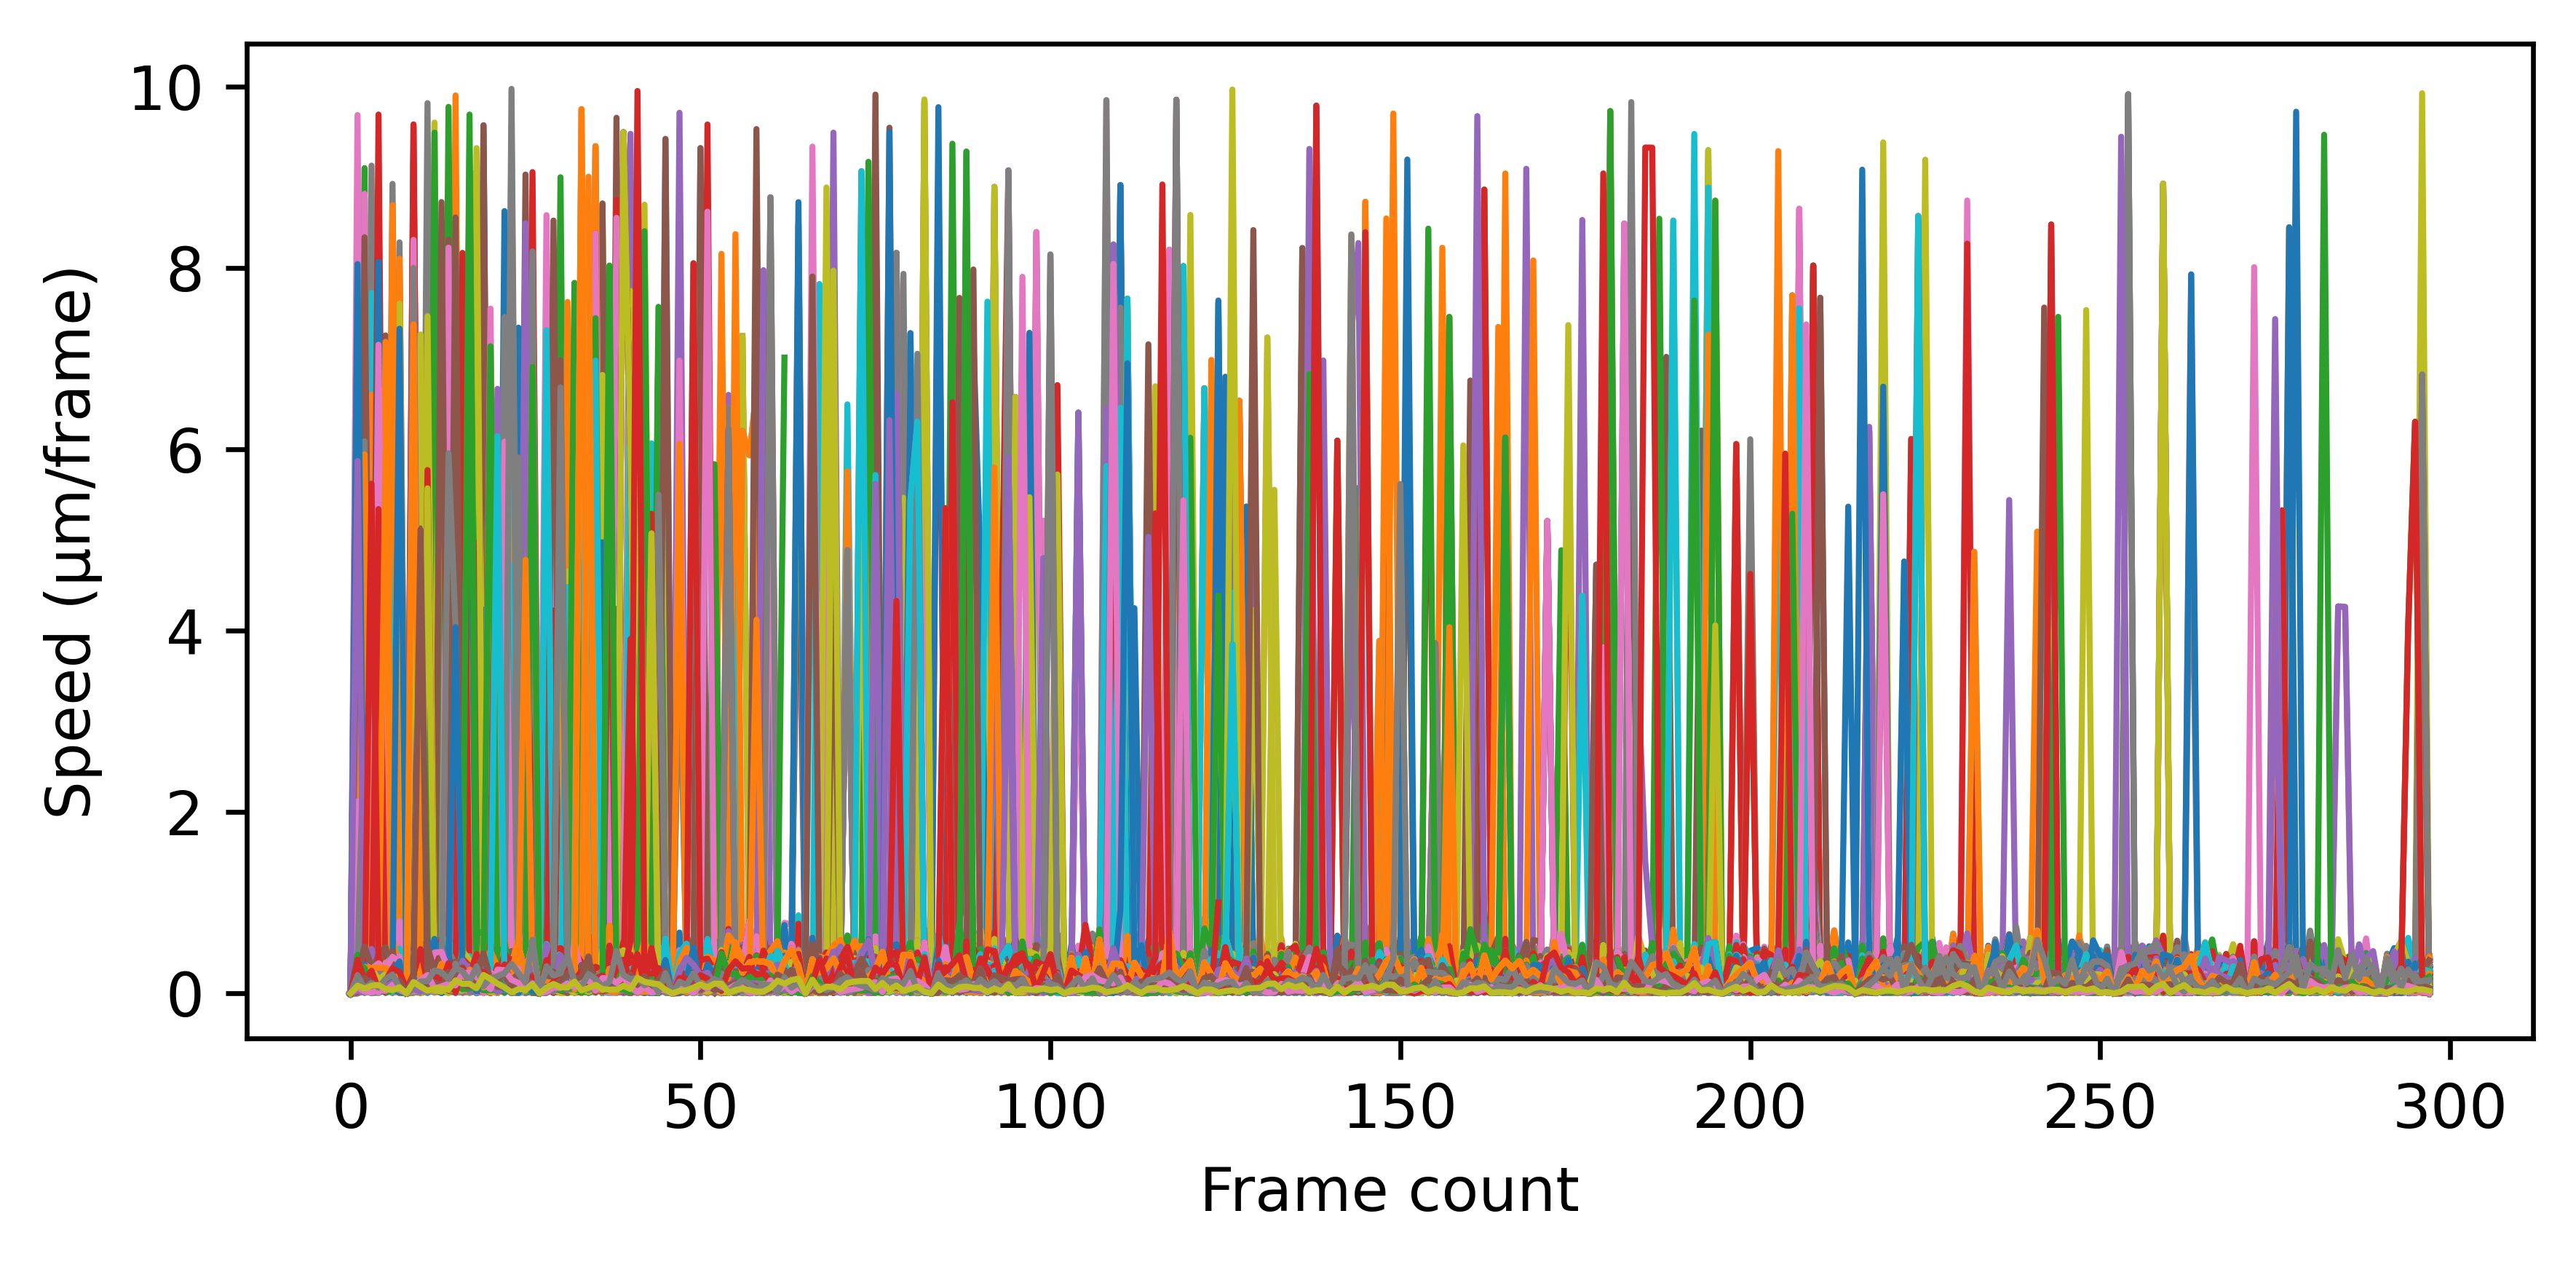

In [268]:
#plot all bead travel
matplotlib.rcParams['pdf.fonttype']=42
fig = plt.figure(figsize=(6,3),dpi=600)

for compartment in beads:
    for bead in beads[compartment]:
        plt.plot(beads[compartment][bead]['travel_um'],linewidth=1)

# plt.ylim(0,1e5)
plt.xlabel('Frame count')
plt.ylabel('Speed (μm/frame)')
plt.tight_layout()
fig.savefig(base_dir + sub + 'plots/' + run + 'travel.jpg', format='jpg')

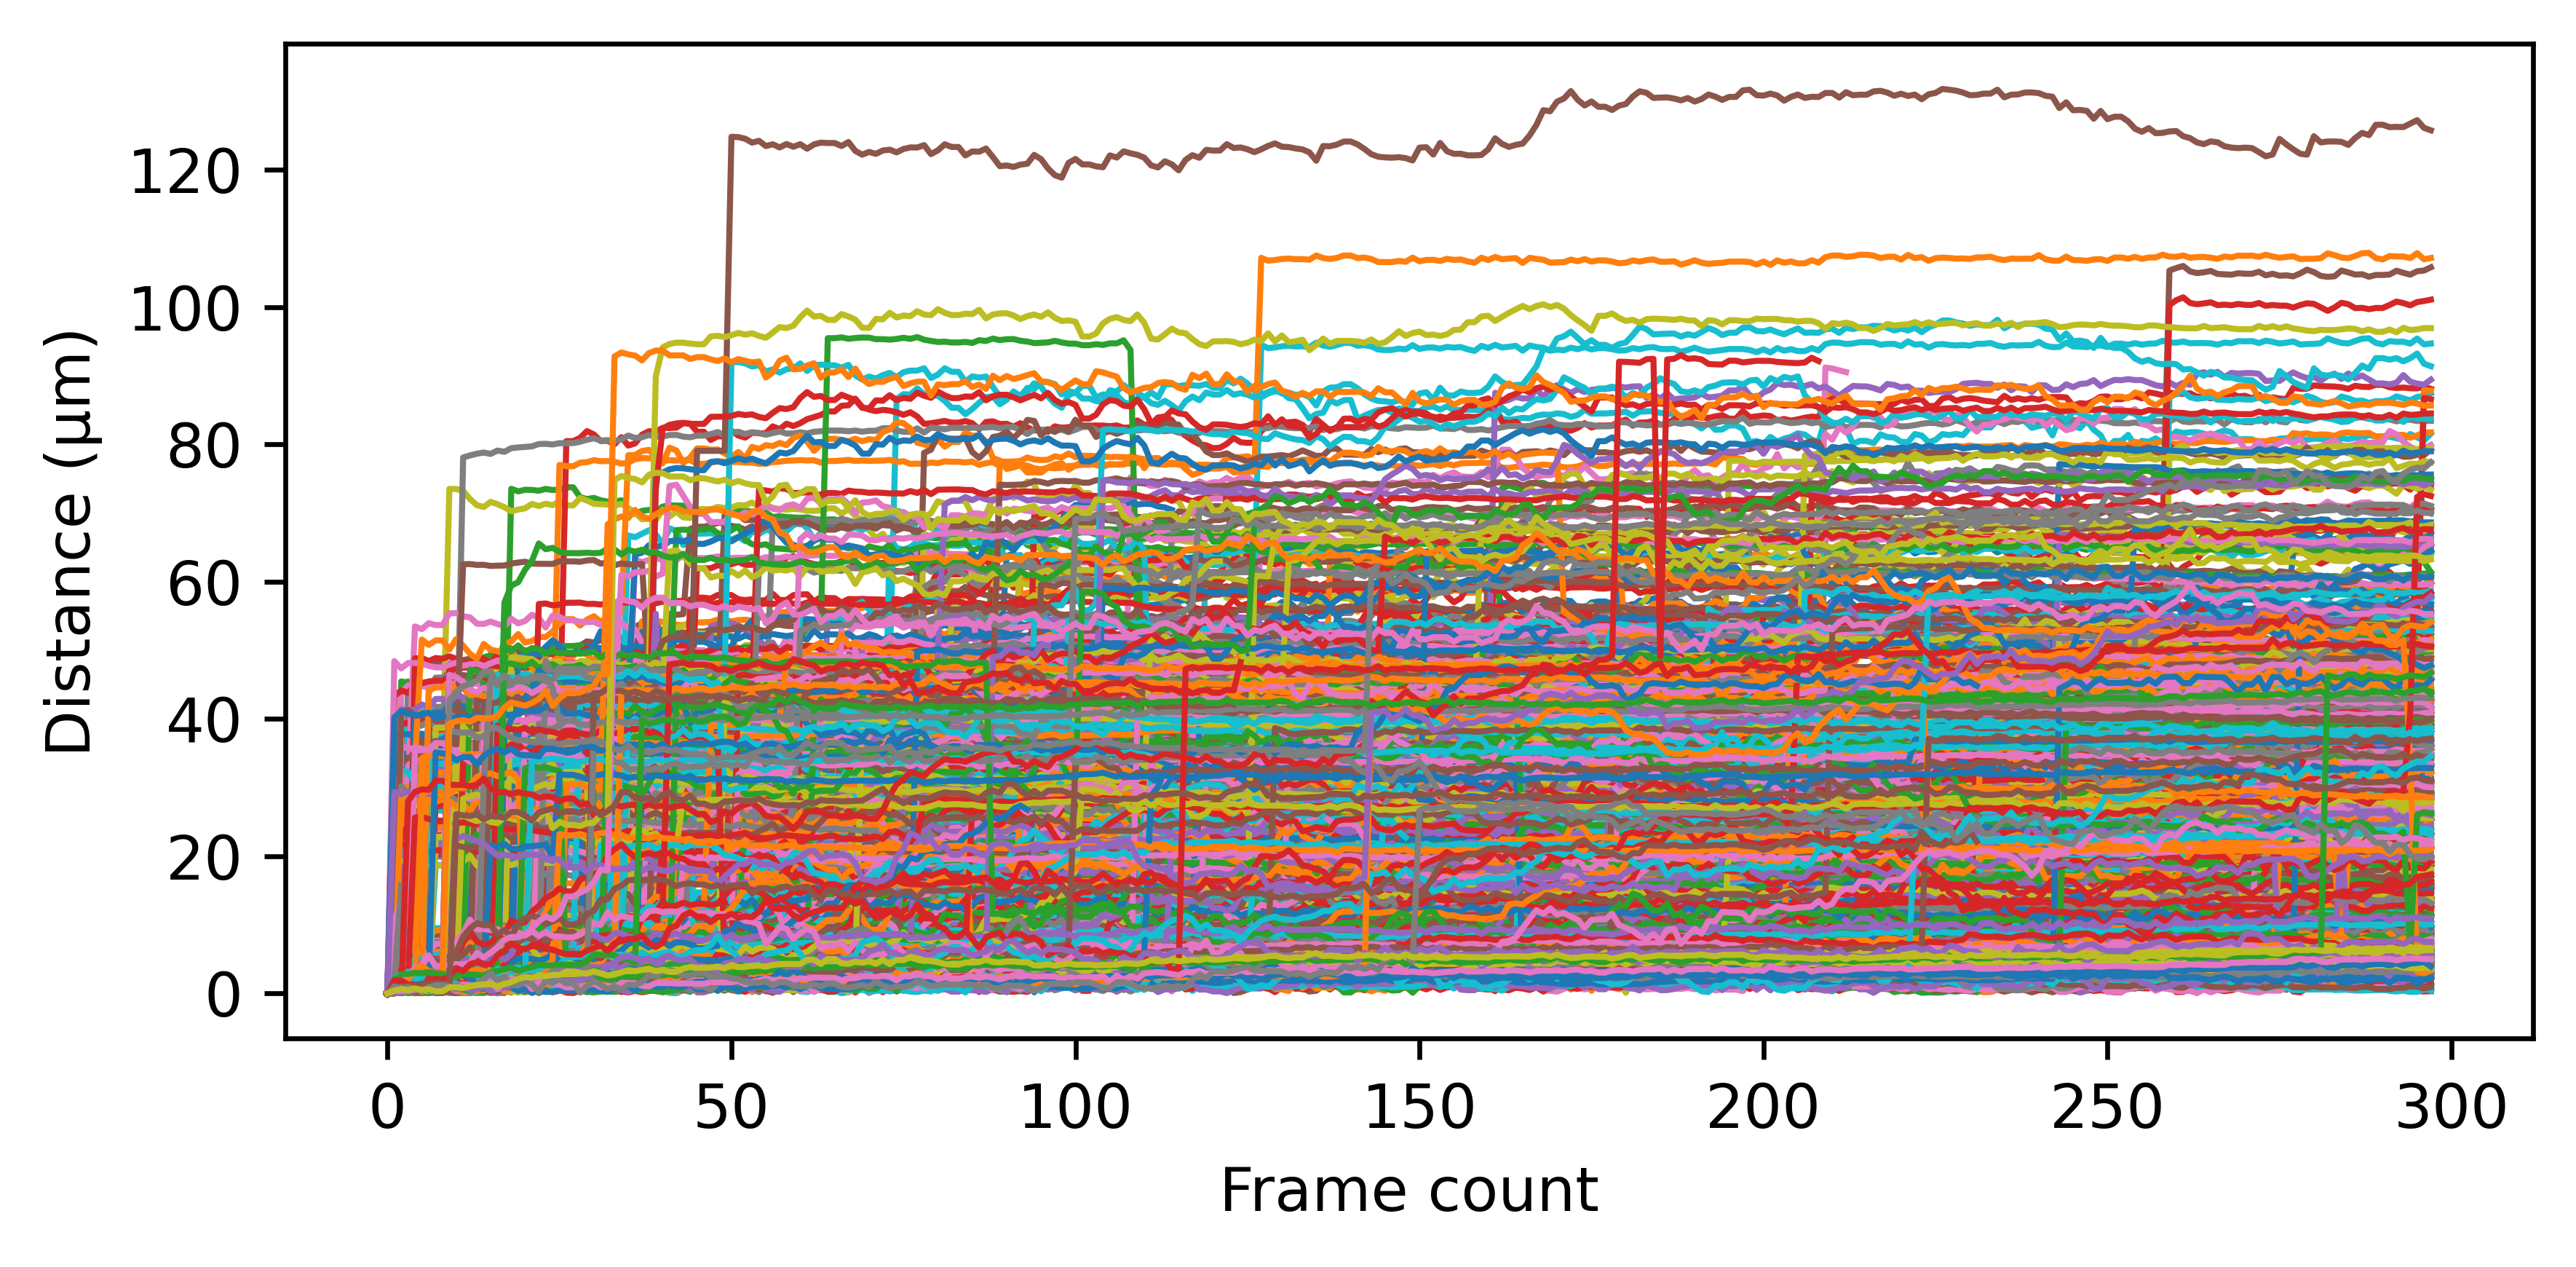

In [269]:
#plot bead distance from start
matplotlib.rcParams['pdf.fonttype']=42
fig = plt.figure(figsize=(6,3),dpi=600)

for compartment in beads:
    for bead in beads[compartment]:
        plt.plot(beads[compartment][bead]['distance_from_start'],linewidth=1)

# plt.ylim(0,1e5)
plt.xlabel('Frame count')
plt.ylabel('Distance (μm)')
plt.tight_layout()
fig.savefig(base_dir + sub + 'plots/' + run + 'distance_from_start.jpg', format='jpg')

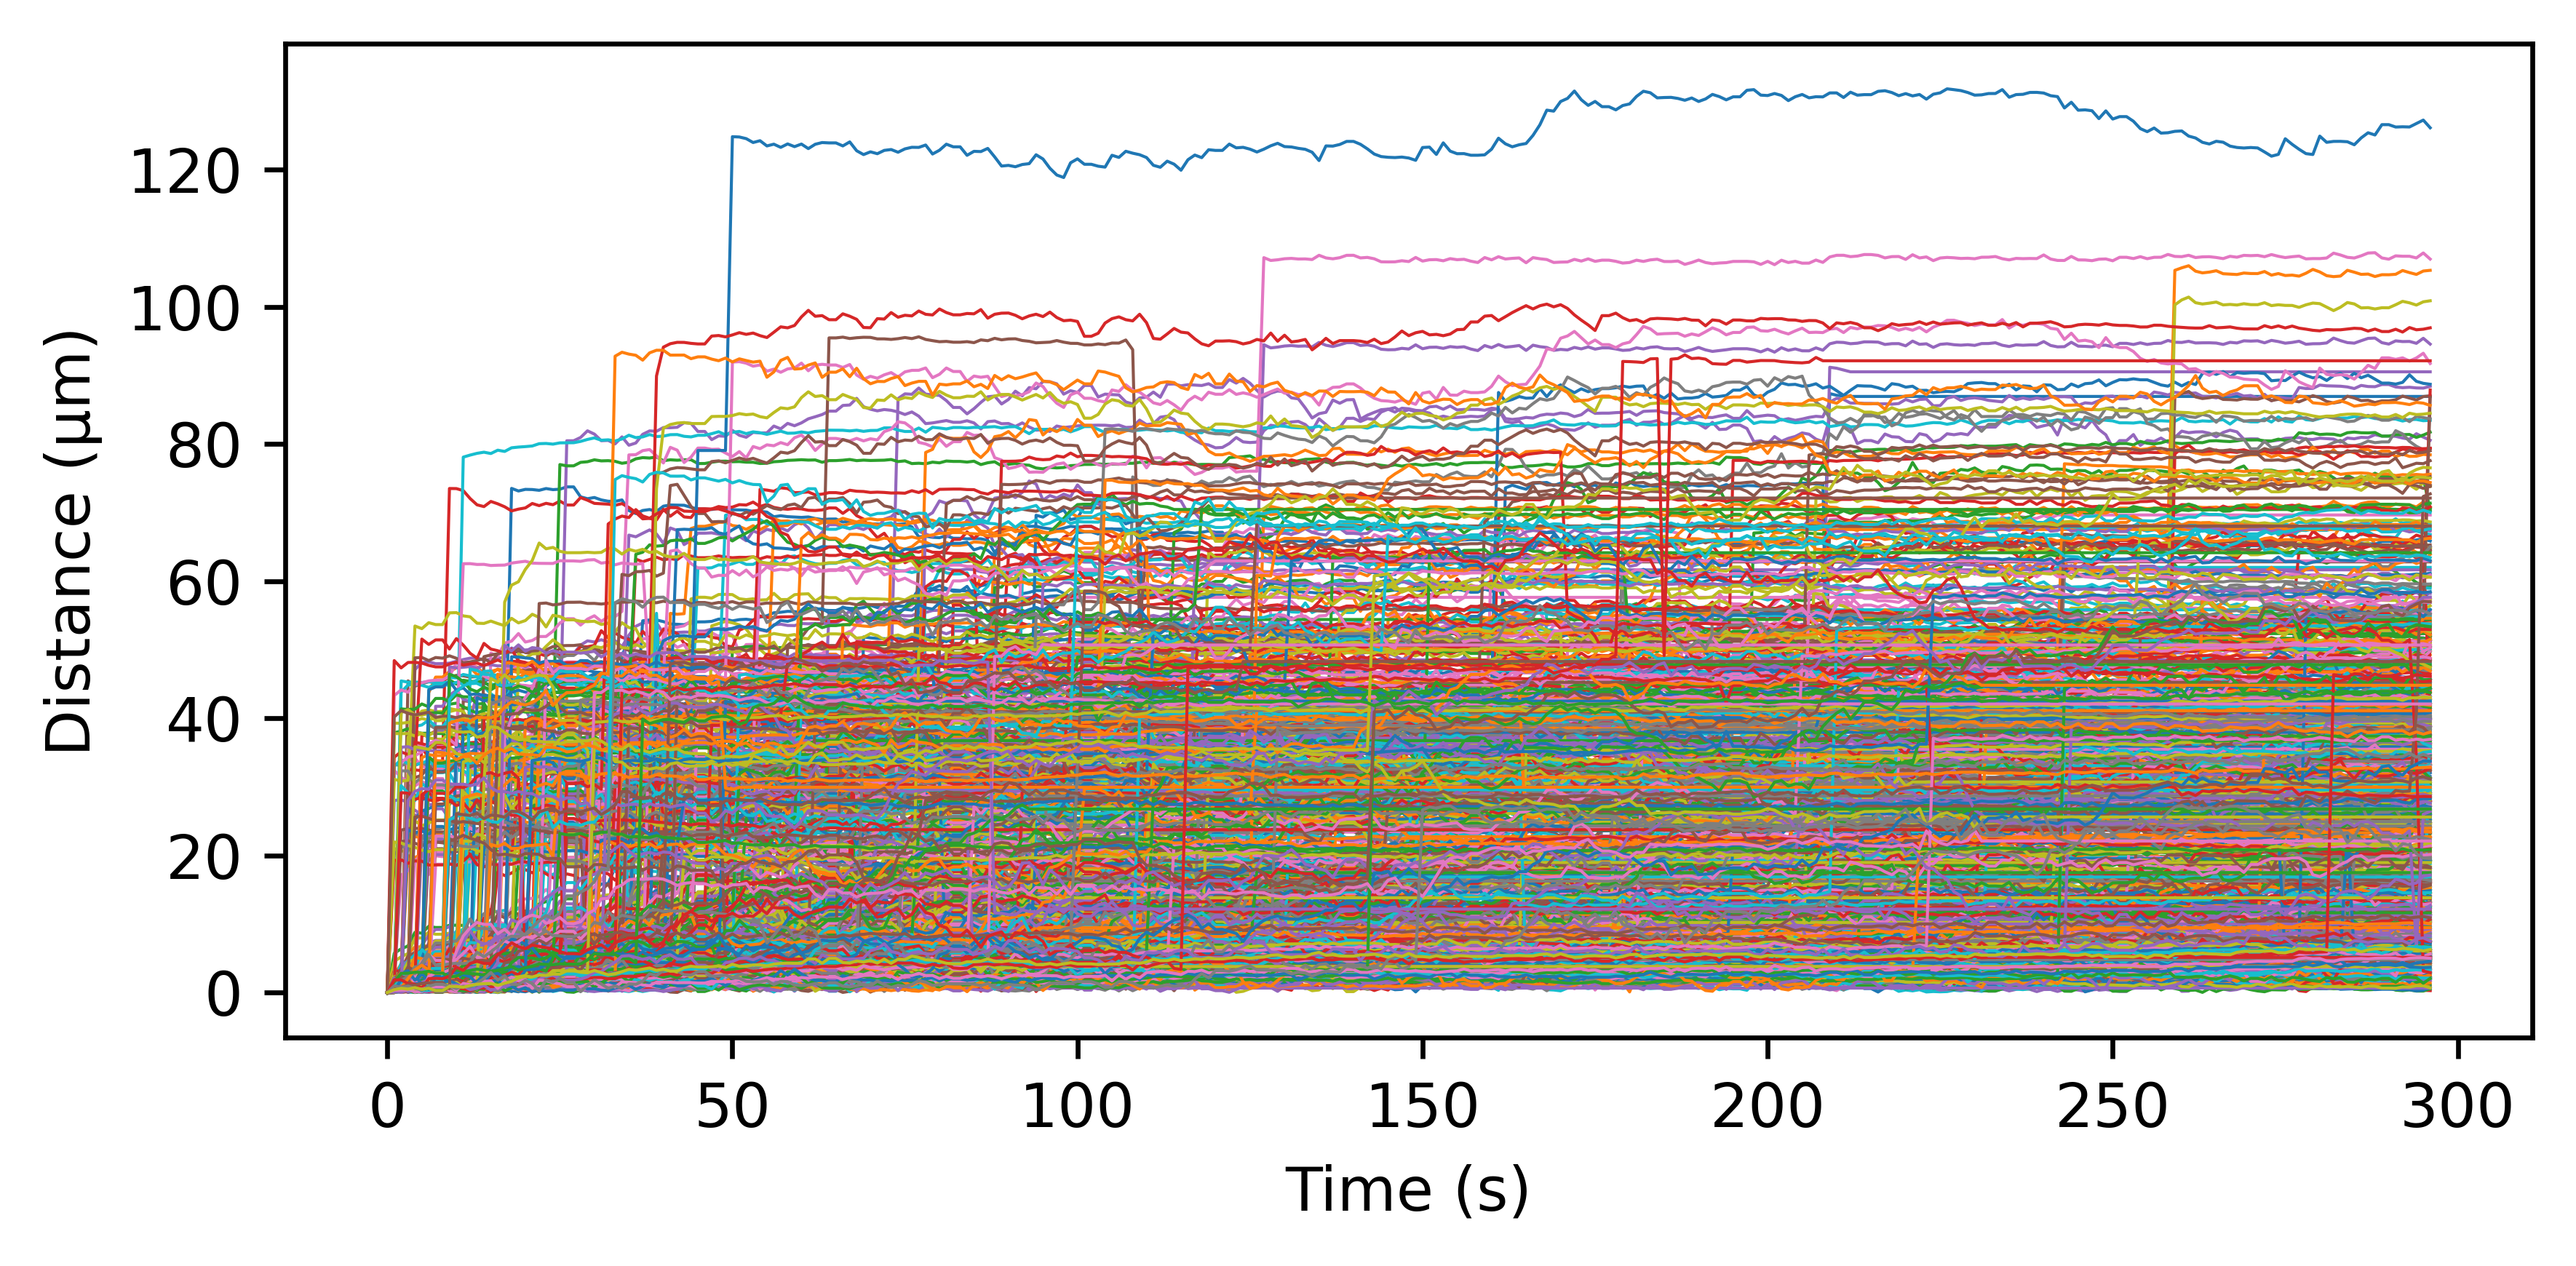

In [270]:
#plot ghosted bead distance from start
matplotlib.rcParams['pdf.fonttype']=42
fig = plt.figure(figsize=(6,3),dpi=600)

for compartment in beads:
    for bead in beads[compartment]:
        means = []
        distances = beads[compartment][bead]['distance_from_start']

        if len(distances) > 50:
            for i in range(d_count):
                if len(distances) < (i+1)*d_frames:
                    mean = means[-1]

                else:
                    mean = np.mean(distances[i*d_frames:i*d_frames+d_frames])

                means.append(mean)

            plt.plot(times,means,linewidth=.5)

# plt.ylim(0,1e5)
plt.xlabel('Time (s)')
plt.ylabel('Distance (μm)')
plt.tight_layout()
fig.savefig(base_dir + sub + 'plots/' + run + 'ghosted_distance_from_start.jpg', format='jpg')

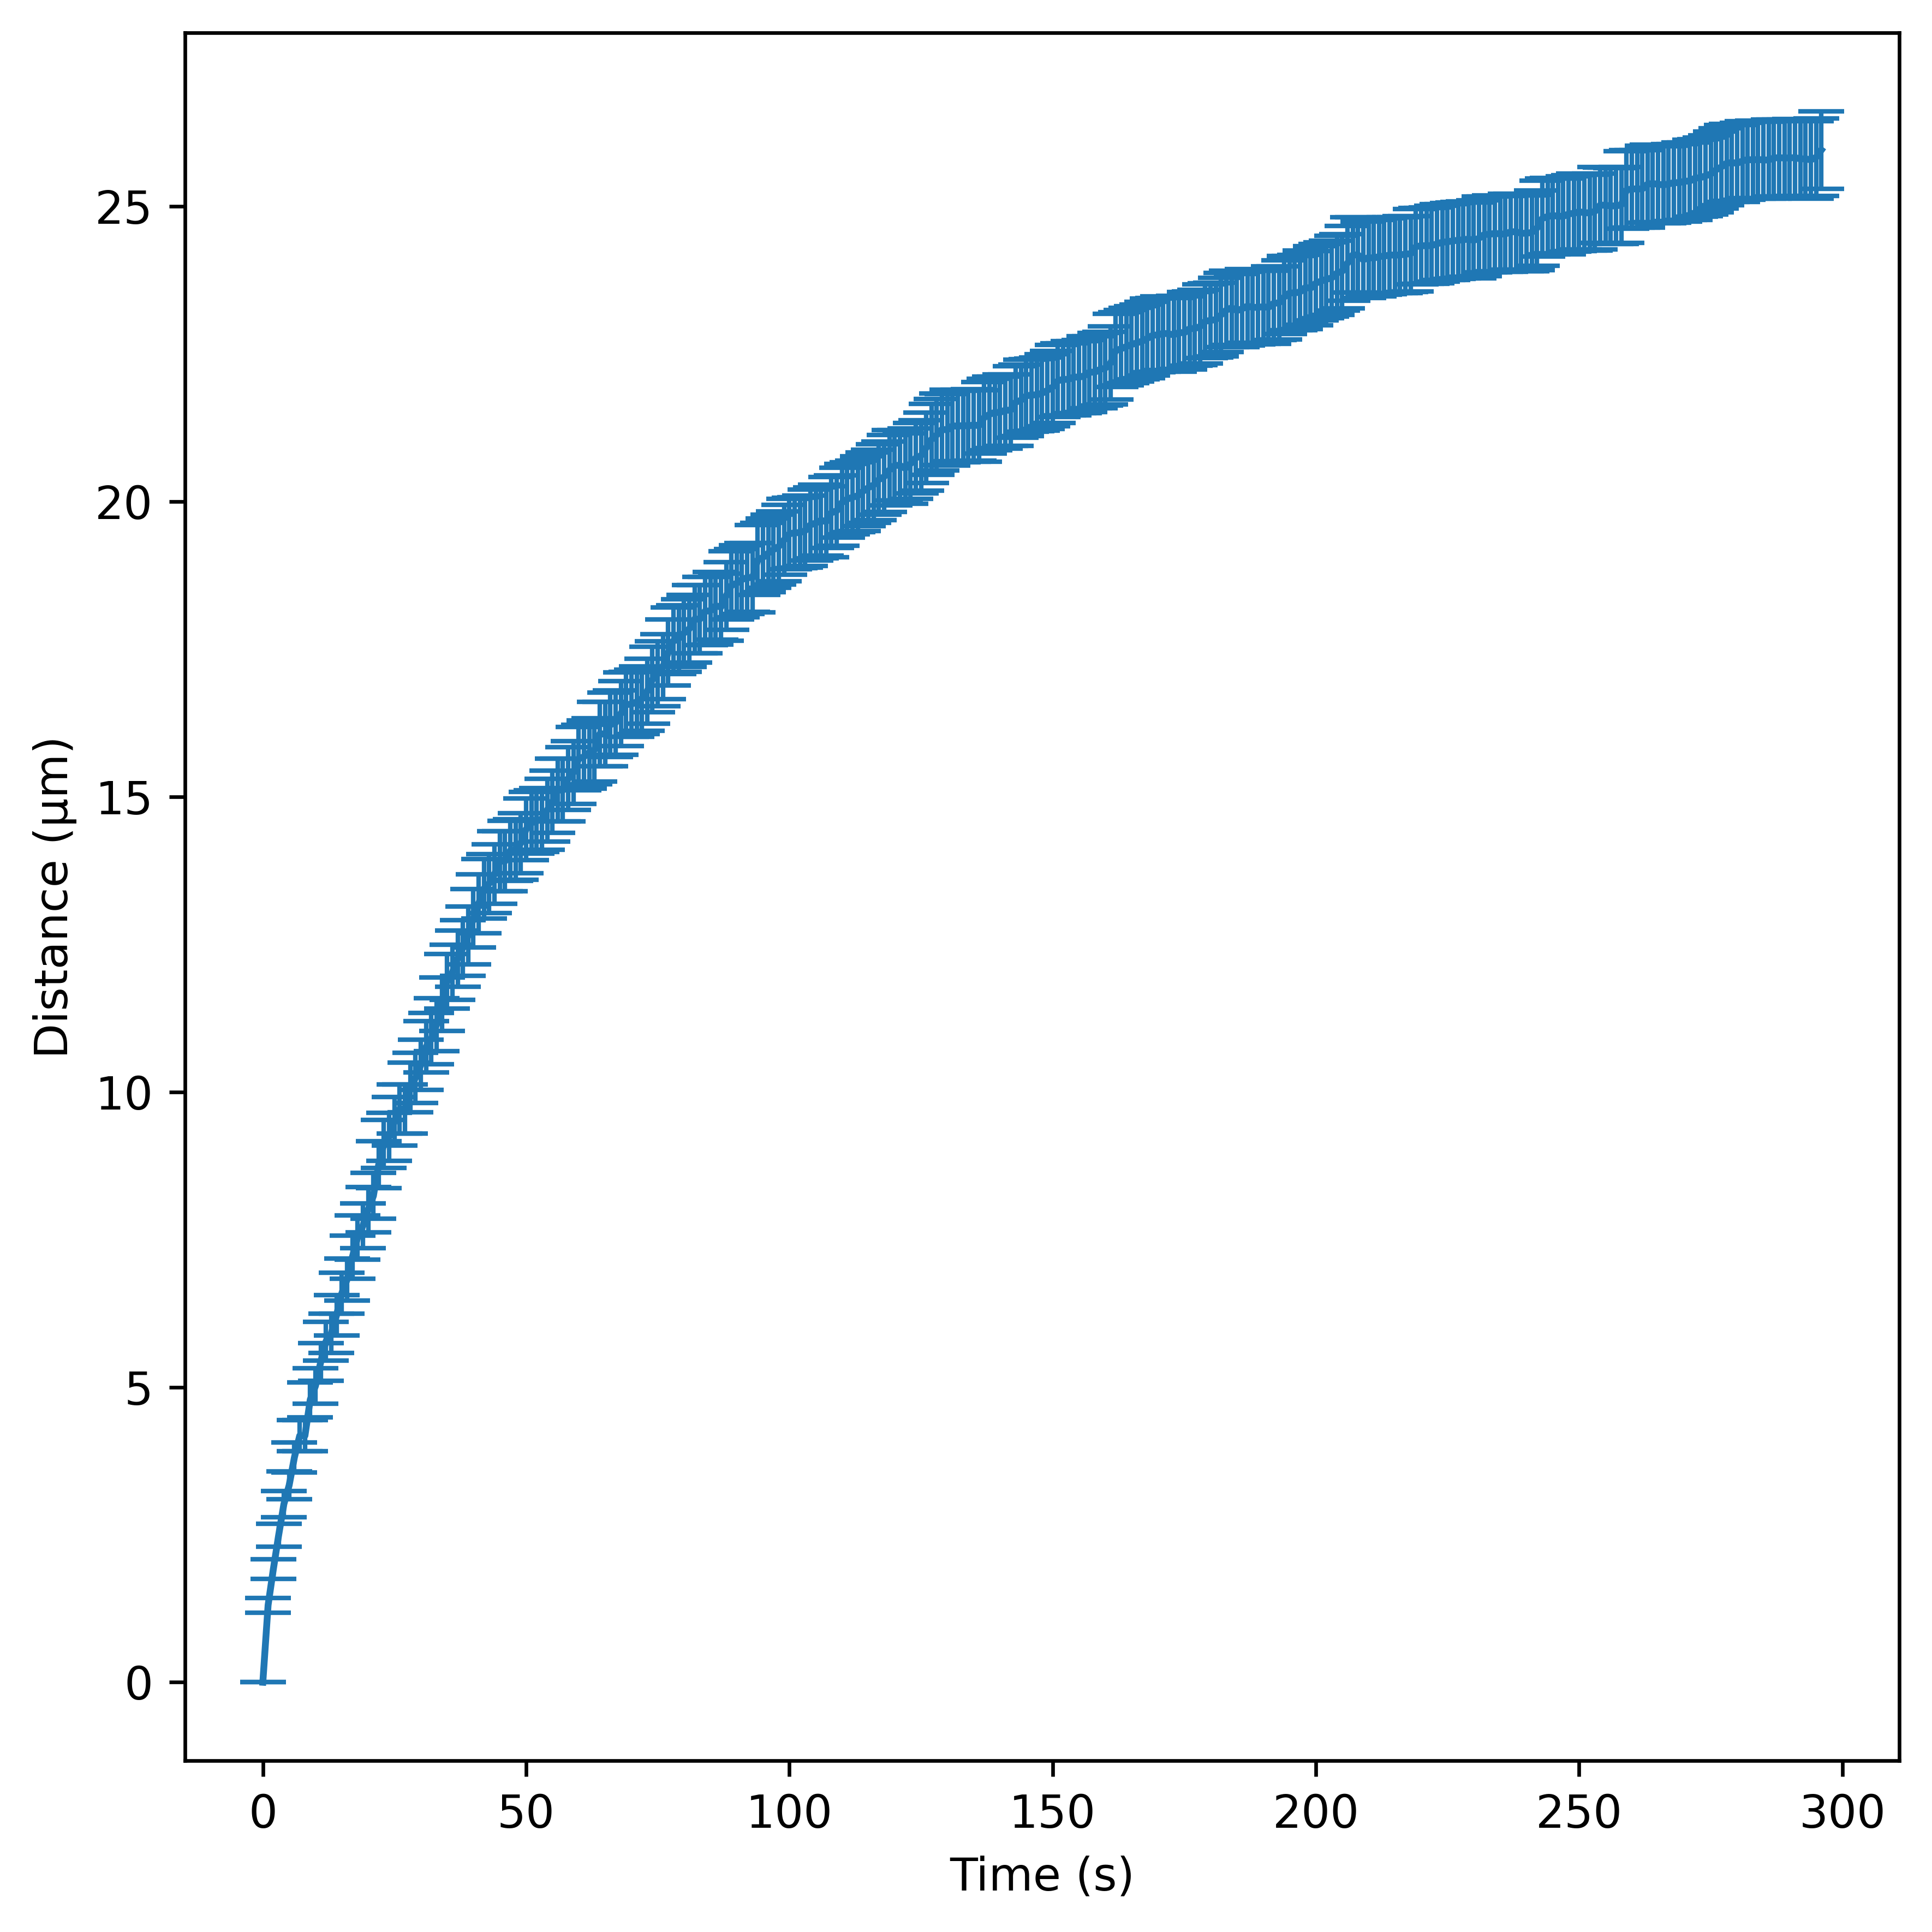

In [271]:
#plot ghosted mean of mean bead distance
matplotlib.rcParams['pdf.fonttype']=42
fig = plt.figure(figsize=(6,6),dpi=600)

means = [[] for _ in range(d_count)]
bead_count = 0
static_threshold = 0.0

for compartment in beads:
    for bead in beads[compartment]:
        bead_means = []
        distances = beads[compartment][bead]['distance_from_start']
        if len(distances) > 50:
            for i in range(d_count):
                if len(distances) < (i+1)*d_frames:
                    mean = bead_means[-1]
                else:
                    mean = np.mean(distances[i*d_frames:i*d_frames+d_frames])

                bead_means.append(mean)
                means[i].append(mean)

            bead_count += 1

full_means = []
full_errors = []

for i in range(d_count):
    collected = means[i]
    full_means.append(np.mean(collected))
    full_errors.append(np.std(collected)/np.sqrt(bead_count))

plt.errorbar(times, full_means, yerr=full_errors, capsize=5, elinewidth=1)
# plt.ylim(0, .15)
# plt.axhline(0,linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Distance (μm)')
plt.tight_layout()
fig.savefig(base_dir + sub + 'plots/' + run + 'sem_mean_mean_ghost_distance_all.jpg', format='jpg')